In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import zipfile

zip_path = '/content/drive/MyDrive/dataset_all.zip'
extract_path = '/content/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [14]:
import os
import shutil

# 原始路徑
base_input_path = '/content/data/dataset_all'  # 改成你解壓縮後的根目錄
base_output_path = '/content/image_classification_data'

splits = ['train', 'val', 'test']

for split in splits:
    image_dir = os.path.join(base_input_path, split, 'images')
    label_dir = os.path.join(base_input_path, split, 'labels')
    output_split_dir = os.path.join(base_output_path, split)

    os.makedirs(output_split_dir, exist_ok=True)

    for label_file in os.listdir(label_dir):
        if not label_file.endswith('.txt'):
            continue

        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if not lines:
                continue
            class_id = lines[0].split()[0]  # YOLO 格式的第一個欄位是類別

        image_name = label_file.replace('.txt', '.jpg')  # 或 .png，根據你的檔名決定
        image_path = os.path.join(image_dir, image_name)

        if not os.path.exists(image_path):
            continue

        class_dir = os.path.join(output_split_dir, class_id)
        os.makedirs(class_dir, exist_ok=True)

        shutil.copy(image_path, os.path.join(class_dir, image_name))


In [15]:
import os
import pandas as pd

def create_multilabel_csv(image_dir, label_dir, output_csv):
    data = []
    for label_file in os.listdir(label_dir):
        if not label_file.endswith('.txt'):
            continue
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if len(lines) == 0:
                continue
            # 擷取每一行的 class_id，放進集合避免重複
            classes = set()
            for line in lines:
                class_id = line.split()[0]
                classes.add(class_id)
        image_name = label_file.replace('.txt', '.jpg')  # 或改成你用的副檔名
        data.append({'image_name': image_name, 'labels': ' '.join(sorted(classes))})

    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Saved multilabel CSV to {output_csv}")

# 範例路徑，改成你實際路徑
train_img_dir = '/content/data/dataset_all/train/images'
train_label_dir = '/content/data/dataset_all/train/labels'
val_img_dir = '/content/data/dataset_all/val/images'
val_label_dir = '/content/data/dataset_all/val/labels'

# 產生CSV
create_multilabel_csv(train_img_dir, train_label_dir, '/content/image_classification_data/train_labels.csv')
create_multilabel_csv(val_img_dir, val_label_dir, '/content/image_classification_data/val_labels.csv')


Saved multilabel CSV to /content/image_classification_data/train_labels.csv
Saved multilabel CSV to /content/image_classification_data/val_labels.csv


In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

# 1. 自訂 Dataset
class MultiLabelDataset(Dataset):
    def __init__(self, csv_path, img_dir, num_classes, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_name'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        labels = row['labels'].split()  # 假設 labels 是以空白隔開的多標籤字串
        multi_hot = torch.zeros(self.num_classes, dtype=torch.float32)
        for l in labels:
            multi_hot[int(l)] = 1.0

        return image, multi_hot

# 2. 設定參數
num_classes = 7  # 你的類別數量，請修改
batch_size = 64
epochs = 20

train_csv = '/content/image_classification_data/train_labels.csv'
val_csv = '/content/image_classification_data/val_labels.csv'
train_dir = '/content/data/dataset_all/train/images'
val_dir = '/content/data/dataset_all/val/images'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # 這是ResNet常用的ImageNet正規化
                         [0.229, 0.224, 0.225])
])

# 3. 建立 Dataset 與 DataLoader
train_dataset = MultiLabelDataset(train_csv, train_dir, num_classes, transform=transform)
val_dataset = MultiLabelDataset(val_csv, val_dir, num_classes, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 4. 建立模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # 🔍 動態推算 Flatten size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            dummy_output = self.features(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).shape[1]  # e.g. 128 * 28 * 28

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
model = SimpleCNN(num_classes=num_classes).to(device)

# 5. 損失函數和優化器
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 6. 訓練與驗證函式
def train_one_epoch():
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(train_dataset)

def validate():
    model.eval()
    threshold = 0.5
    correct_per_class = torch.zeros(num_classes)
    total_per_class = torch.zeros(num_classes)

    total_correct = 0
    total_preds = 0
    total_labels = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).float()

            # per-class 正確數與總數
            correct_per_class += ((preds == labels) * labels).sum(dim=0).cpu()
            total_per_class += labels.sum(dim=0).cpu()

            # micro F1 所需的統計
            total_correct += (preds * labels).sum().item()
            total_preds += preds.sum().item()
            total_labels += labels.sum().item()

    # per-label accuracy
    per_label_accuracy = (correct_per_class / (total_per_class + 1e-8)).mean().item()

    # micro-average F1
    precision = total_correct / (total_preds + 1e-8)
    recall = total_correct / (total_labels + 1e-8)
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0

    return per_label_accuracy, precision, recall, f1

# 7. 主訓練迴圈
best_accuracy = 0.0  # 初始化最佳 accuracy

for epoch in range(epochs):
    train_loss = train_one_epoch()
    per_label_accuracy, precision, recall, f1 = validate()
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Per-label Accuracy={per_label_accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

    # 只保留最佳模型
    if per_label_accuracy > best_accuracy:
        best_accuracy = per_label_accuracy
        save_path = "best_model.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Best model updated and saved with accuracy: {best_accuracy:.4f}")



KeyboardInterrupt: 

In [ ]:
# 儲存模型
torch.save(model.state_dict(), '20epochs_model_weights.pth')


In [8]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn

# === 1. 建立 test CSV（從 label 檔推得 image 名）===
def create_multilabel_csv(image_dir, label_dir, output_csv):
    data = []
    for label_file in os.listdir(label_dir):
        if not label_file.endswith('.txt'):
            continue
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if len(lines) == 0:
                continue
            classes = set()
            for line in lines:
                class_id = line.split()[0]
                classes.add(class_id)
        image_name = label_file.replace('.txt', '.jpg')  # 確認副檔名是否正確
        data.append({'image_name': image_name, 'labels': ' '.join(sorted(classes))})

    pd.DataFrame(data).to_csv(output_csv, index=False)
    print(f"✅ Test CSV saved to {output_csv}")

# === 2. 自訂 Dataset 類 ===
class MultiLabelDataset(Dataset):
    def __init__(self, csv_path, img_dir, num_classes, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_name'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        labels = row['labels'].split()
        multi_hot = torch.zeros(self.num_classes, dtype=torch.float32)
        for l in labels:
            multi_hot[int(l)] = 1.0

        return image, multi_hot, row['image_name']

# === 3. 資料與模型設定 ===
num_classes = 7
test_img_dir = '/content/data/dataset_all/test/images'
test_label_dir = '/content/data/dataset_all/test/labels'
test_csv_path = '/content/image_classification_data/test_labels.csv'
create_multilabel_csv(test_img_dir, test_label_dir, test_csv_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 4. 載入模型 ===
model = SimpleCNN(num_classes=num_classes).to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
# === 5. 測試與評估 ===
from sklearn.metrics import precision_score, recall_score, f1_score

test_dataset = MultiLabelDataset(test_csv_path, test_img_dir, num_classes, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64)

threshold = 0.5
results = []

correct_per_class = torch.zeros(num_classes)
total_per_class = torch.zeros(num_classes)

# Micro-averaged 計數
total_correct = 0
total_preds = 0
total_labels = 0

# 每一筆的 y_true / y_pred（for macro 指標）
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, img_names in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).float()

        # 累積每一類的準確數
        correct_per_class += ((preds == labels) * labels).sum(dim=0).cpu()
        total_per_class += labels.sum(dim=0).cpu()

        # Micro-averaged 計數
        total_correct += (preds * labels).sum().item()
        total_preds += preds.sum().item()
        total_labels += labels.sum().item()

        # 收集所有 prediction & label（for macro）
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

        # 儲存預測結果（for 輸出 CSV）
        for name, pred in zip(img_names, preds.cpu()):
            label_indices = [str(i) for i, val in enumerate(pred) if val == 1]
            results.append({'image_name': name, 'labels': ' '.join(label_indices)})

# === 指標計算 ===
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Macro 指標
macro_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
macro_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

# Micro 指標
precision = total_correct / (total_preds + 1e-8)
recall = total_correct / (total_labels + 1e-8)
f1 = 2 * precision * recall / (precision + recall + 1e-8)

# Per-label Accuracy
per_label_accuracy = (correct_per_class / (total_per_class + 1e-8))

print("📊 Evaluation Results")
print(f"🎯 Micro:")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall:    {recall:.4f}")
print(f"  - F1-score:  {f1:.4f}")
print(f"\n🎯 Macro:")
print(f"  - Precision: {macro_precision:.4f}")
print(f"  - Recall:    {macro_recall:.4f}")
print(f"  - F1-score:  {macro_f1:.4f}")
print(f"\n🎯 Per-label Accuracy (mean): {per_label_accuracy.mean().item():.4f}\n")

for i, acc in enumerate(per_label_accuracy):
    print(f"  - Label {i}: Accuracy = {acc.item():.4f}")

# 儲存預測結果 CSV
output_csv = '/content/test_predictions.csv'
pd.DataFrame(results).to_csv(output_csv, index=False)
print(f"\n✅ Prediction CSV saved to {output_csv}")



✅ Test CSV saved to /content/image_classification_data/test_labels.csv
📊 Evaluation Results
🎯 Micro:
  - Precision: 0.8218
  - Recall:    0.7238
  - F1-score:  0.7697

🎯 Macro:
  - Precision: 0.8297
  - Recall:    0.6743
  - F1-score:  0.7348

🎯 Per-label Accuracy (mean): 0.6743

  - Label 0: Accuracy = 0.7901
  - Label 1: Accuracy = 0.7111
  - Label 2: Accuracy = 0.7073
  - Label 3: Accuracy = 0.5000
  - Label 4: Accuracy = 0.7059
  - Label 5: Accuracy = 0.4500
  - Label 6: Accuracy = 0.8554

✅ Prediction CSV saved to /content/test_predictions.csv


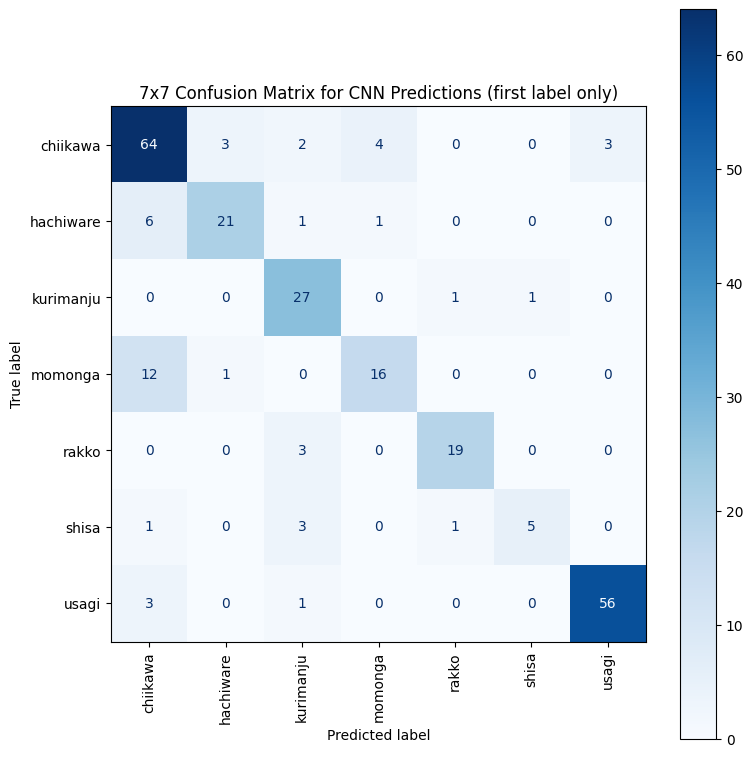

In [12]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 類別資訊
num_classes = 7
labels = ['chiikawa', 'hachiware', 'kurimanju', 'momonga', 'rakko', 'shisa', 'usagi']

# 讀取 Ground Truth 和 預測結果 CSV
true_csv_path = '/content/image_classification_data/test_labels.csv'
pred_csv_path = '/content/test_predictions.csv'

true_df = pd.read_csv(true_csv_path)
pred_df = pd.read_csv(pred_csv_path)

# 轉換為 dict 方便查找（image_name -> class list）
true_dict = {row['image_name']: row['labels'].split() for _, row in true_df.iterrows()}
pred_dict = {
    row['image_name']: str(row['labels']).split()
    for _, row in pred_df.iterrows()
    if pd.notna(row['labels'])
}


# 收集第一個類別作為單標籤評估（若無預測或標註則略過）
y_true, y_pred = [], []

for img_name in sorted(true_dict.keys()):
    if img_name not in pred_dict:
        continue  # 沒有預測的跳過

    true_labels = true_dict[img_name]
    pred_labels = pred_dict[img_name]

    if not true_labels or not pred_labels:
        continue  # 空的跳過

    # 取第一個類別（以 int 型態儲存）
    y_true.append(int(true_labels[0]))
    y_pred.append(int(pred_labels[0]))

# === 畫 Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("7x7 Confusion Matrix for CNN Predictions (first label only)")
plt.tight_layout()
plt.show()


=== 多標籤分類完整分析 ===

1. 每個類別的二元混淆矩陣:


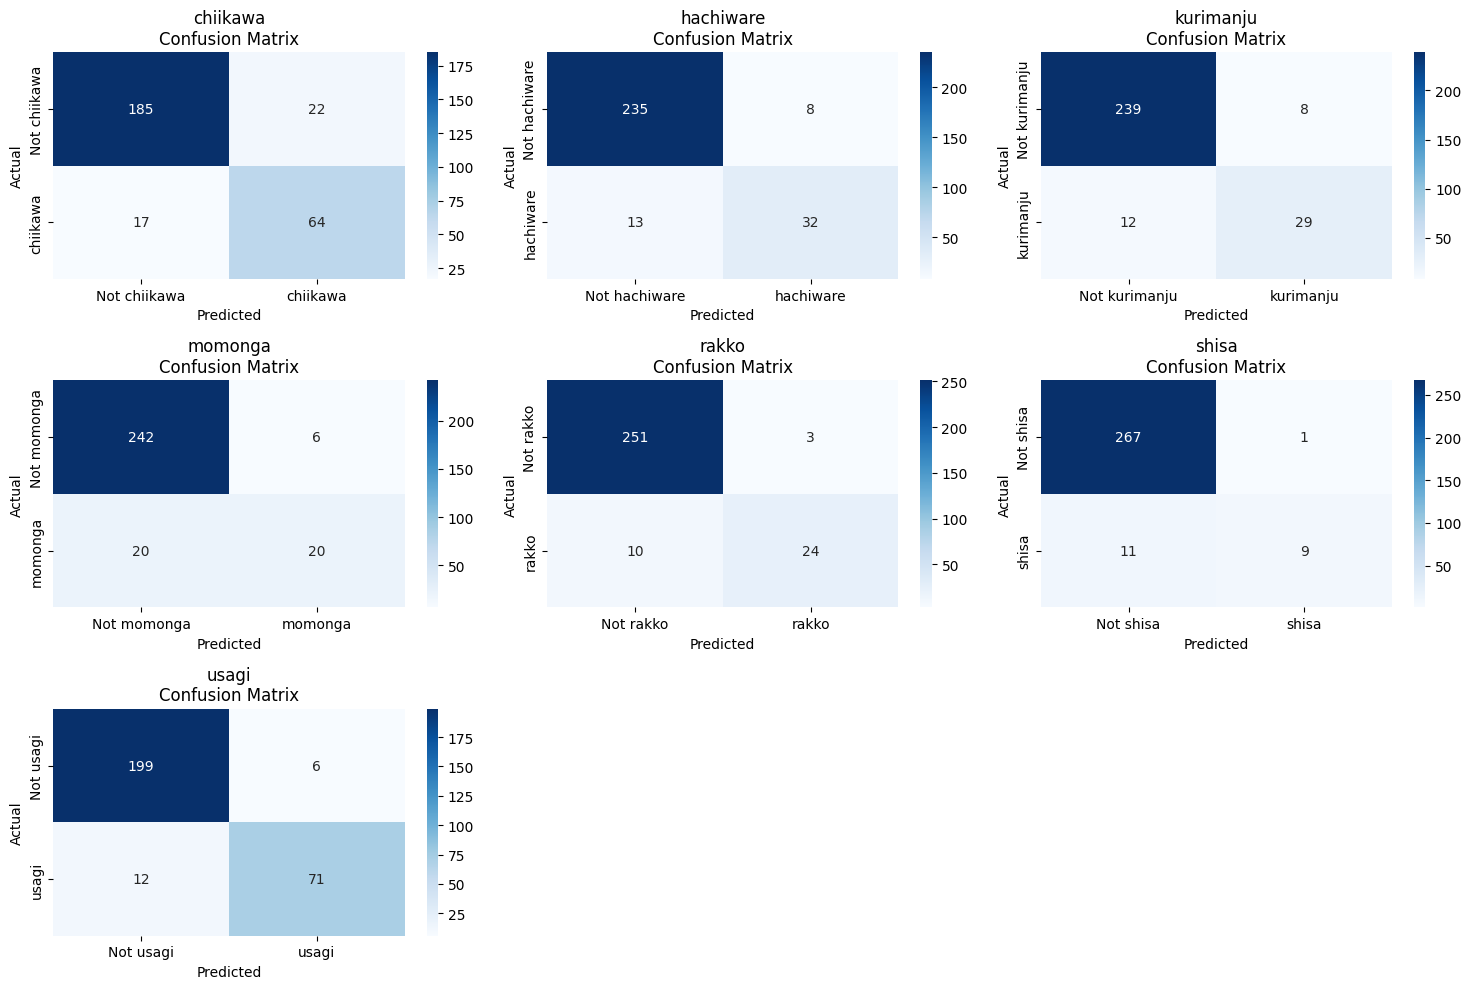


2. 每個類別的詳細指標:
       Class  TP   TN  FP  FN  Precision  Recall  F1-Score  Specificity  \
0   chiikawa  64  185  22  17      0.744   0.790     0.766        0.894   
1  hachiware  32  235   8  13      0.800   0.711     0.753        0.967   
2  kurimanju  29  239   8  12      0.784   0.707     0.744        0.968   
3    momonga  20  242   6  20      0.769   0.500     0.606        0.976   
4      rakko  24  251   3  10      0.889   0.706     0.787        0.988   
5      shisa   9  267   1  11      0.900   0.450     0.600        0.996   
6      usagi  71  199   6  12      0.922   0.855     0.888        0.971   

   Accuracy  
0     0.865  
1     0.927  
2     0.931  
3     0.910  
4     0.955  
5     0.958  
6     0.938  

3. 標籤頻率比較:


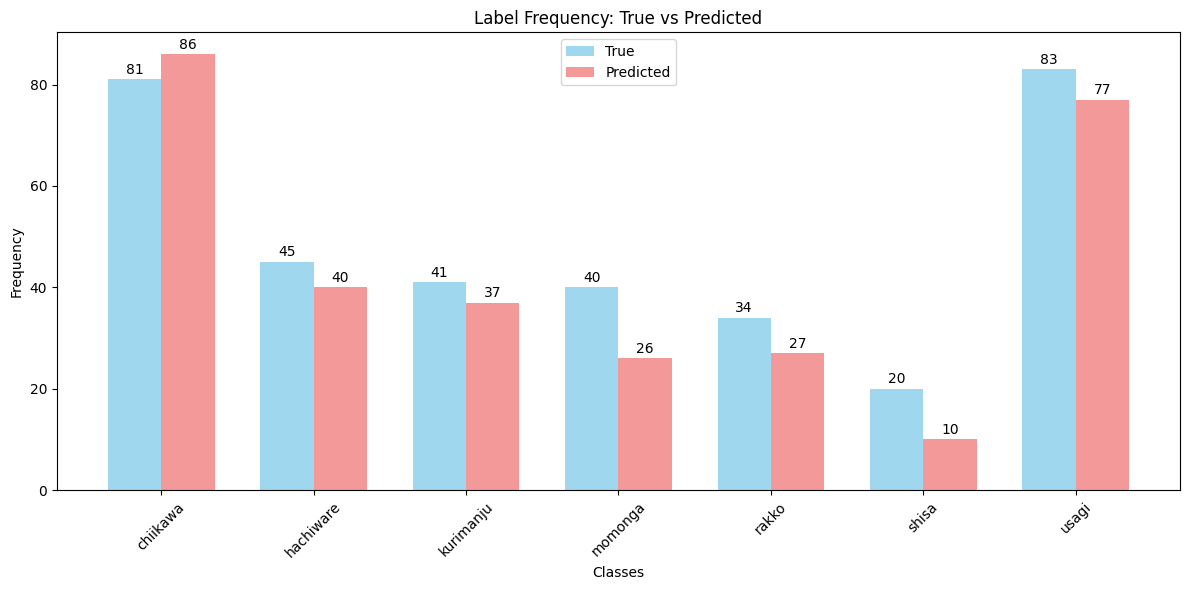


4. 標籤共現矩陣:


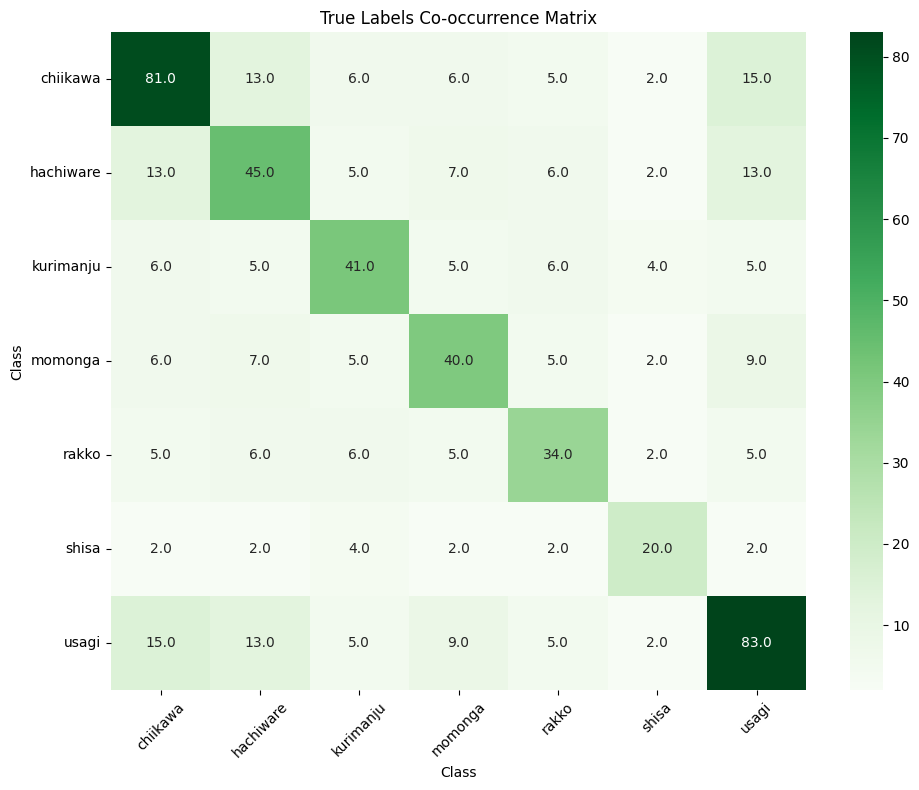

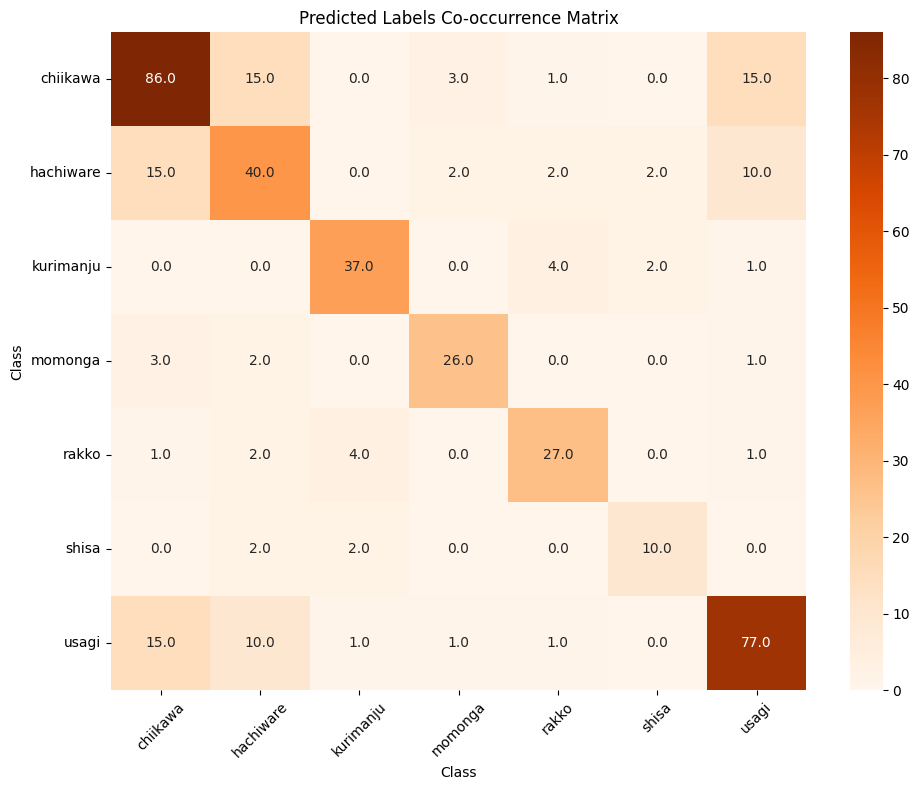


5. 子集준確度分析:


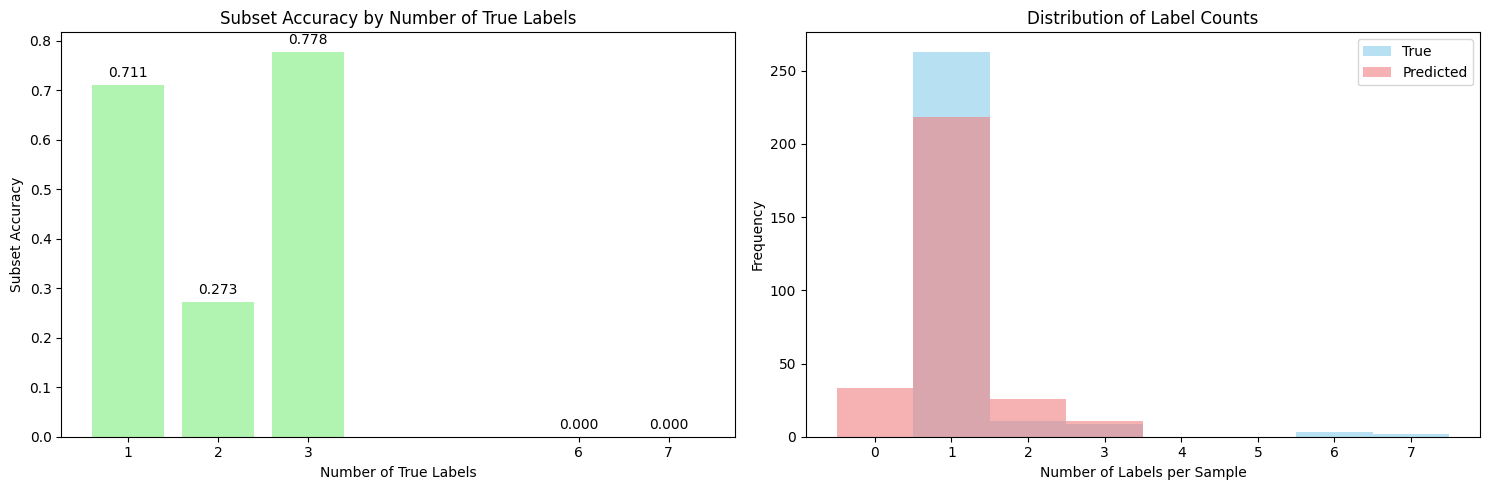

Overall Subset Accuracy: 0.684


In [11]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import pandas as pd
class_names = ['chiikawa', 'hachiware', 'kurimanju', 'momonga', 'rakko', 'shisa', 'usagi']

def plot_multilabel_confusion_matrices(y_true, y_pred, class_names, figsize=(15, 10)):
    """
    為每個類別繪製二元混淆矩陣 (每個類別 vs 其他所有類別)
    """
    # 計算多標籤混淆矩陣
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    n_classes = len(class_names)
    cols = 3
    rows = (n_classes + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if n_classes > 1 else [axes]

    for i, class_name in enumerate(class_names):
        cm = mcm[i]

        # 繪製熱力圖
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Not ' + class_name, class_name],
                   yticklabels=['Not ' + class_name, class_name])
        axes[i].set_title(f'{class_name}\nConfusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    # 隱藏多餘的子圖
    for i in range(n_classes, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    return mcm


def plot_label_cooccurrence_matrix(y_true, y_pred, class_names, plot_type='both'):
    """
    繪製標籤共現矩陣 (顯示哪些標籤經常一起出現)
    """
    if plot_type in ['true', 'both']:
        # 真實標籤的共現矩陣
        true_cooc = np.dot(y_true.T, y_true)

        plt.figure(figsize=(10, 8))
        sns.heatmap(true_cooc, annot=True, fmt='.1f', cmap='Greens',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('True Labels Co-occurrence Matrix')
        plt.xlabel('Class')
        plt.ylabel('Class')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    if plot_type in ['pred', 'both']:
        # 預測標籤的共現矩陣
        pred_cooc = np.dot(y_pred.T, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(pred_cooc, annot=True, fmt='.1f', cmap='Oranges',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Predicted Labels Co-occurrence Matrix')
        plt.xlabel('Class')
        plt.ylabel('Class')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()


def plot_label_frequency_comparison(y_true, y_pred, class_names):
    """
    比較真實標籤和預測標籤的頻率分布
    """
    true_freq = y_true.sum(axis=0)
    pred_freq = y_pred.sum(axis=0)

    x = np.arange(len(class_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width/2, true_freq, width, label='True', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, pred_freq, width, label='Predicted', alpha=0.8, color='lightcoral')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Frequency')
    ax.set_title('Label Frequency: True vs Predicted')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45)
    ax.legend()

    # 在柱狀圖上顯示數值
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


def compute_multilabel_metrics_per_class(y_true, y_pred, class_names):
    """
    計算每個類別的詳細指標
    """
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    metrics_data = []

    for i, class_name in enumerate(class_names):
        tn, fp, fn, tp = mcm[i].ravel()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        metrics_data.append({
            'Class': class_name,
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Specificity': specificity,
            'Accuracy': accuracy
        })

    df = pd.DataFrame(metrics_data)
    return df


def plot_subset_accuracy_analysis(y_true, y_pred, class_names):
    """
    分析子集準確度 (exact match) 的詳細情況
    """
    # 計算每個樣本的匹配情況
    exact_matches = np.all(y_true == y_pred, axis=1)
    subset_accuracy = np.mean(exact_matches)

    # 統計不同標籤數量的準確度
    true_label_counts = y_true.sum(axis=1)
    pred_label_counts = y_pred.sum(axis=1)

    # 按真實標籤數量分組的準確度
    unique_counts = np.unique(true_label_counts)
    accuracy_by_count = []

    for count in unique_counts:
        mask = (true_label_counts == count)
        if np.any(mask):
            acc = np.mean(exact_matches[mask])
            accuracy_by_count.append(acc)
        else:
            accuracy_by_count.append(0)

    # 繪製圖表
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 子圖1: 按標籤數量的準確度
    ax1.bar(unique_counts, accuracy_by_count, alpha=0.7, color='lightgreen')
    ax1.set_xlabel('Number of True Labels')
    ax1.set_ylabel('Subset Accuracy')
    ax1.set_title('Subset Accuracy by Number of True Labels')
    ax1.set_xticks(unique_counts)

    # 在柱狀圖上顯示數值
    for i, acc in enumerate(accuracy_by_count):
        ax1.text(unique_counts[i], acc + 0.01, f'{acc:.3f}',
                ha='center', va='bottom')

    # 子圖2: 標籤數量分布比較
    bins = np.arange(0, max(max(true_label_counts), max(pred_label_counts)) + 2) - 0.5
    ax2.hist(true_label_counts, bins=bins, alpha=0.6, label='True', color='skyblue')
    ax2.hist(pred_label_counts, bins=bins, alpha=0.6, label='Predicted', color='lightcoral')
    ax2.set_xlabel('Number of Labels per Sample')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Label Counts')
    ax2.legend()
    ax2.set_xticks(range(int(max(max(true_label_counts), max(pred_label_counts))) + 1))

    plt.tight_layout()
    plt.show()

    print(f"Overall Subset Accuracy: {subset_accuracy:.3f}")
    return subset_accuracy


def comprehensive_multilabel_analysis(y_true, y_pred, class_names):
    """
    完整的多標籤分類分析
    """
    print("=== 多標籤分類完整分析 ===\n")

    # 1. 每個類別的混淆矩陣
    print("1. 每個類別的二元混淆矩陣:")
    mcm = plot_multilabel_confusion_matrices(y_true, y_pred, class_names)

    # 2. 每個類別的詳細指標
    print("\n2. 每個類別的詳細指標:")
    metrics_df = compute_multilabel_metrics_per_class(y_true, y_pred, class_names)
    print(metrics_df.round(3))

    # 3. 標籤頻率比較
    print("\n3. 標籤頻率比較:")
    plot_label_frequency_comparison(y_true, y_pred, class_names)

    # 4. 標籤共現分析
    print("\n4. 標籤共現矩陣:")
    plot_label_cooccurrence_matrix(y_true, y_pred, class_names)

    # 5. 子集準確度分析
    print("\n5. 子集준確度分析:")
    subset_acc = plot_subset_accuracy_analysis(y_true, y_pred, class_names)

    return {
        'confusion_matrices': mcm,
        'metrics_per_class': metrics_df,
        'subset_accuracy': subset_acc
    }


# 修改原評估函數以包含多標籤分析
def evaluate_model_with_multilabel_analysis(model, test_loader, class_names, device='cuda',
                                          threshold=0.5, show_analysis=True):
    """
    評估模型並進行完整的多標籤分析
    """

    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels, *_ in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probs = torch.sigmoid(outputs)
            predictions = (probs > threshold).float()

            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)

    if show_analysis:
        # 進行完整的多標籤分析
        analysis_results = comprehensive_multilabel_analysis(
            all_labels, all_predictions, class_names
        )
        return all_predictions, all_labels, all_probs, analysis_results
    else:
        return all_predictions, all_labels, all_probs


def load_predictions_from_csv(csv_file=None, pred_csv=None, true_csv=None, class_names=None):
    """
    從 CSV 檔案讀取預測結果和真實標籤

    方法1 - 單一 CSV 檔案格式:
    image_name,predicted_labels,true_labels
    case_001,0 2,0 2
    case_002,1 4 5,1 4
    case_003,,0 1 3

    方法2 - 分開的兩個 CSV 檔案:
    pred.csv: image_name,labels
    true.csv: image_name,labels
    """

    if csv_file is not None:
        # 方法1: 單一檔案包含兩者
        df = pd.read_csv(csv_file)
        n_samples = len(df)
        n_classes = len(class_names)

        y_pred = np.zeros((n_samples, n_classes))
        y_true = np.zeros((n_samples, n_classes))

        for i, row in df.iterrows():
            # 處理預測標籤
            if pd.notna(row['predicted_labels']) and str(row['predicted_labels']).strip():
                pred_indices = [int(x) for x in str(row['predicted_labels']).split()]
                y_pred[i, pred_indices] = 1

            # 處理真實標籤
            if pd.notna(row['true_labels']) and str(row['true_labels']).strip():
                true_indices = [int(x) for x in str(row['true_labels']).split()]
                y_true[i, true_indices] = 1

        return y_true, y_pred

    elif pred_csv is not None and true_csv is not None:
        # 方法2: 分開的兩個檔案
        pred_df = pd.read_csv(pred_csv)
        true_df = pd.read_csv(true_csv)

        # 確保兩個檔案有相同的 image_name 順序
        pred_df = pred_df.sort_values('image_name').reset_index(drop=True)
        true_df = true_df.sort_values('image_name').reset_index(drop=True)

        # 檢查 image_name 是否匹配
        if not pred_df['image_name'].equals(true_df['image_name']):
            print("警告: 預測檔案和真實標籤檔案的 image_name 不完全匹配!")
            # 取交集
            common_ids = set(pred_df['image_name']) & set(true_df['image_name'])
            pred_df = pred_df[pred_df['image_name'].isin(common_ids)].sort_values('image_name').reset_index(drop=True)
            true_df = true_df[true_df['image_name'].isin(common_ids)].sort_values('image_name').reset_index(drop=True)
            print(f"使用共同的 {len(common_ids)} 個案例")

        n_samples = len(pred_df)
        n_classes = len(class_names)

        y_pred = np.zeros((n_samples, n_classes))
        y_true = np.zeros((n_samples, n_classes))

        # 處理預測標籤
        for i, row in pred_df.iterrows():
            if pd.notna(row['labels']) and str(row['labels']).strip():
                pred_indices = [int(x) for x in str(row['labels']).split()]
                y_pred[i, pred_indices] = 1

        # 處理真實標籤
        for i, row in true_df.iterrows():
            if pd.notna(row['labels']) and str(row['labels']).strip():
                true_indices = [int(x) for x in str(row['labels']).split()]
                y_true[i, true_indices] = 1

        return y_true, y_pred

    else:
        raise ValueError("請提供 csv_file 或 (pred_csv 和 true_csv)")


def load_predictions_from_separate_files(pred_csv, true_csv, class_names):
    """
    從兩個分開的 CSV 檔案讀取預測結果和真實標籤

    兩個檔案格式都是:
    image_name,labels
    case_001,0 2
    case_002,1 4 5
    case_003,
    """
    return load_predictions_from_csv(pred_csv=pred_csv, true_csv=true_csv, class_names=class_names)

def analyze_predictions_from_csv(csv_file=None, pred_csv=None, true_csv=None, class_names=None):
    """
    從 CSV 檔案進行多標籤分析

    使用方法:
    1. 單一檔案: analyze_predictions_from_csv(csv_file='combined.csv', class_names=class_names)
    2. 分開檔案: analyze_predictions_from_csv(pred_csv='pred.csv', true_csv='true.csv', class_names=class_names)
    """
    if csv_file is not None:
        print(f"從單一 CSV 檔案讀取預測結果: {csv_file}")
        y_true, y_pred = load_predictions_from_csv(csv_file=csv_file, class_names=class_names)
    elif pred_csv is not None and true_csv is not None:
        print(f"從分開的 CSV 檔案讀取預測結果:")
        print(f"  預測檔案: {pred_csv}")
        print(f"  真實標籤檔案: {true_csv}")
        y_true, y_pred = load_predictions_from_csv(pred_csv=pred_csv, true_csv=true_csv, class_names=class_names)
    else:
        raise ValueError("請提供 csv_file 或 (pred_csv 和 true_csv)")

    print(f"讀取了 {len(y_true)} 個樣本，{len(class_names)} 個類別")

    # 進行完整分析
    return comprehensive_multilabel_analysis(y_true, y_pred, class_names)

# 使用範例
# """
# class_names = model = SimpleCNN(num_classes=num_classes).to(device)
model = SimpleCNN(num_classes=num_classes).to(device)
model.load_state_dict(torch.load('best_model.pth', weights_only=False))
# # 方法1: 從模型直接評估
predictions, labels, probs, analysis = evaluate_model_with_multilabel_analysis(
    model=model,
    test_loader=test_loader,
    class_names=class_names,
    device='cuda',
    threshold=0.5,
    show_analysis=True
)

# # 方法2: 從單一 CSV 檔案分析（包含預測和真實標籤）
# analysis_results = analyze_predictions_from_csv(
#     csv_file='predictions.csv',
#     class_names=class_names
# )

# # 方法3: 從兩個分開的 CSV 檔案分析
# analysis_results = analyze_predictions_from_csv(
#     pred_csv='predictions.csv',
#     true_csv='ground_truth.csv',
#     class_names=class_names
# )

# # 方法4: 手動載入後分析
# # 單一檔案
# y_true, y_pred = load_predictions_from_csv(csv_file='combined.csv', class_names=class_names)

# # 或分開的檔案
# y_true, y_pred = load_predictions_from_csv(pred_csv='pred.csv', true_csv='true.csv', class_names=class_names)

# # 然後分析
# analysis_results = comprehensive_multilabel_analysis(y_true, y_pred, class_names)
# """



# # 如果是單一檔案
# analysis = analyze_predictions_from_csv(
#     csv_file='combined_results.csv',
#     class_names=class_names
# )

# # 如果是兩個分開的檔案
# analysis = analyze_predictions_from_csv(
#     pred_csv='test_predictions.csv',
#     true_csv='ground_truth.csv',
#     class_names=class_names
# )



從分開的 CSV 檔案讀取預測結果:
  預測檔案: /content/test_predictions.csv
  真實標籤檔案: /content/image_classification_data/test_labels.csv
讀取了 288 個樣本，7 個類別
=== 多標籤分類完整分析 ===

1. 每個類別的二元混淆矩陣:


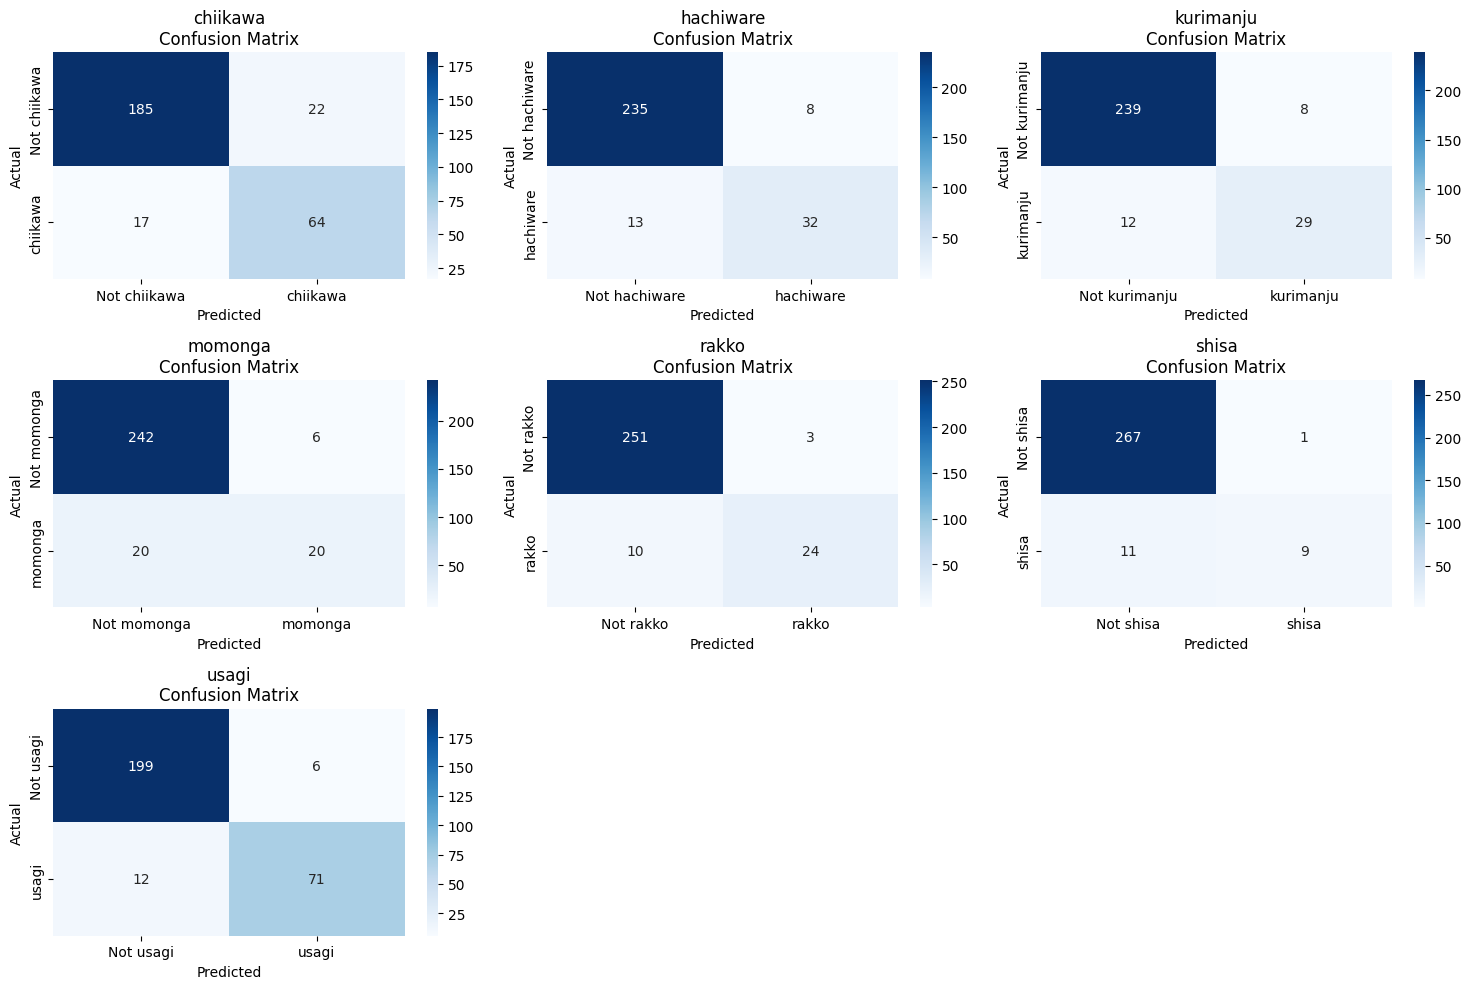


2. 每個類別的詳細指標:
       Class  TP   TN  FP  FN  Precision  Recall  F1-Score  Specificity  \
0   chiikawa  64  185  22  17      0.744   0.790     0.766        0.894   
1  hachiware  32  235   8  13      0.800   0.711     0.753        0.967   
2  kurimanju  29  239   8  12      0.784   0.707     0.744        0.968   
3    momonga  20  242   6  20      0.769   0.500     0.606        0.976   
4      rakko  24  251   3  10      0.889   0.706     0.787        0.988   
5      shisa   9  267   1  11      0.900   0.450     0.600        0.996   
6      usagi  71  199   6  12      0.922   0.855     0.888        0.971   

   Accuracy  
0     0.865  
1     0.927  
2     0.931  
3     0.910  
4     0.955  
5     0.958  
6     0.938  

3. 標籤頻率比較:


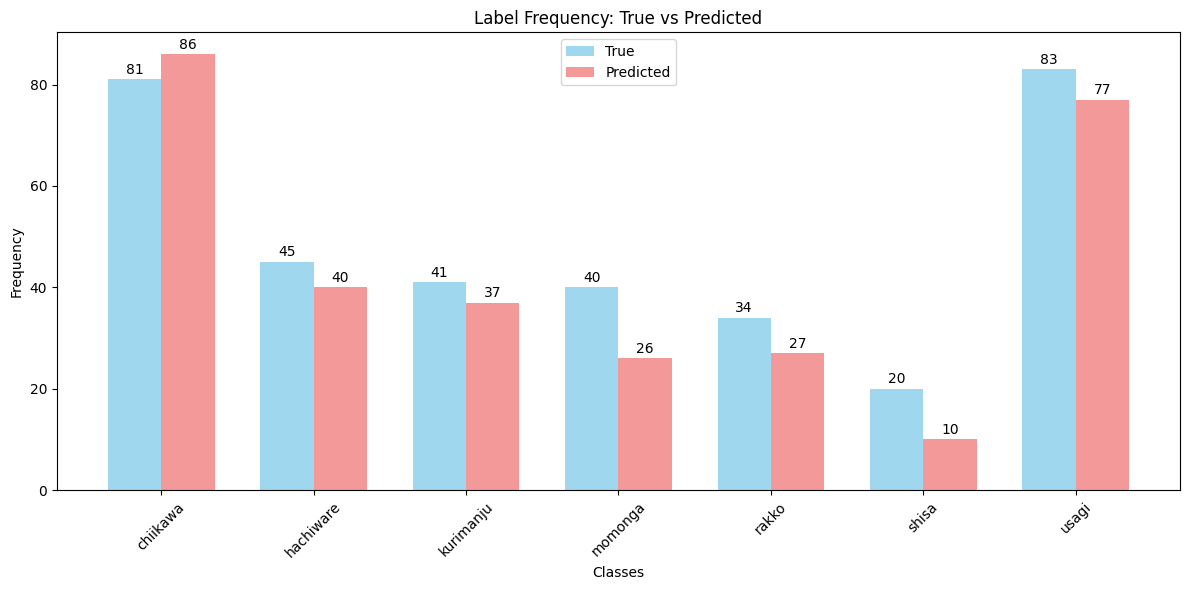


4. 標籤共現矩陣:


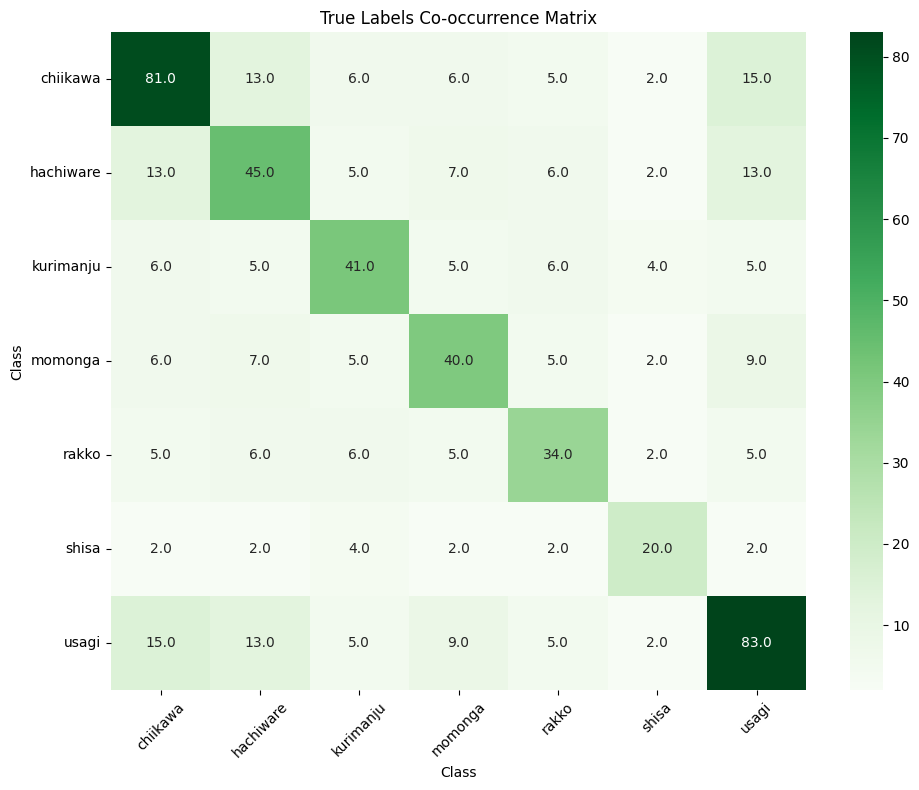

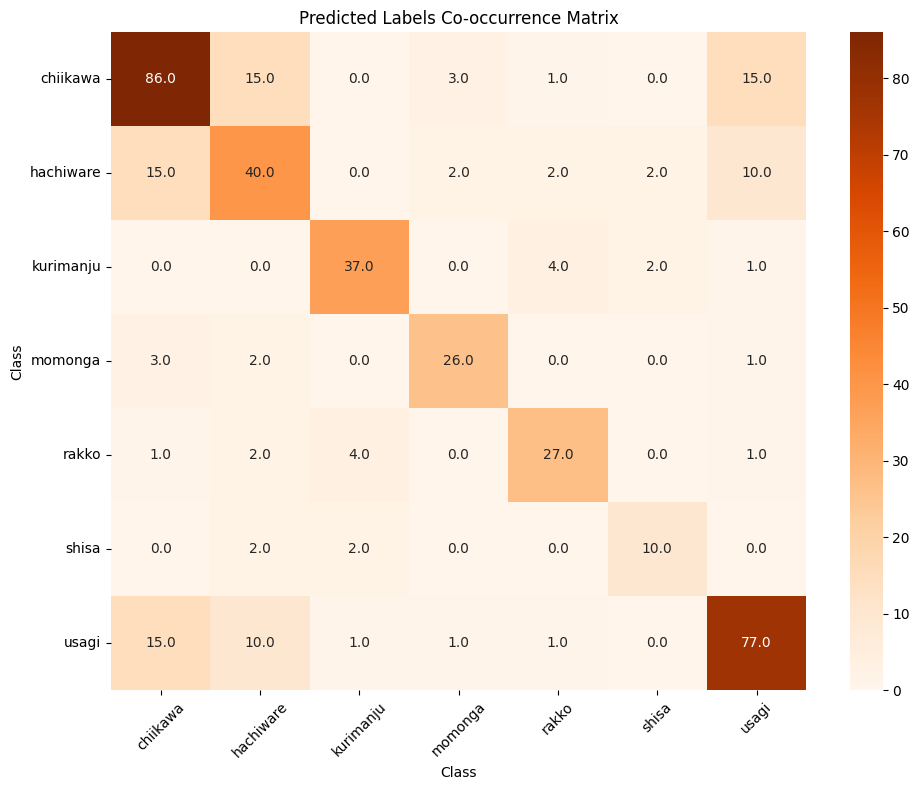


5. 子集준確度分析:


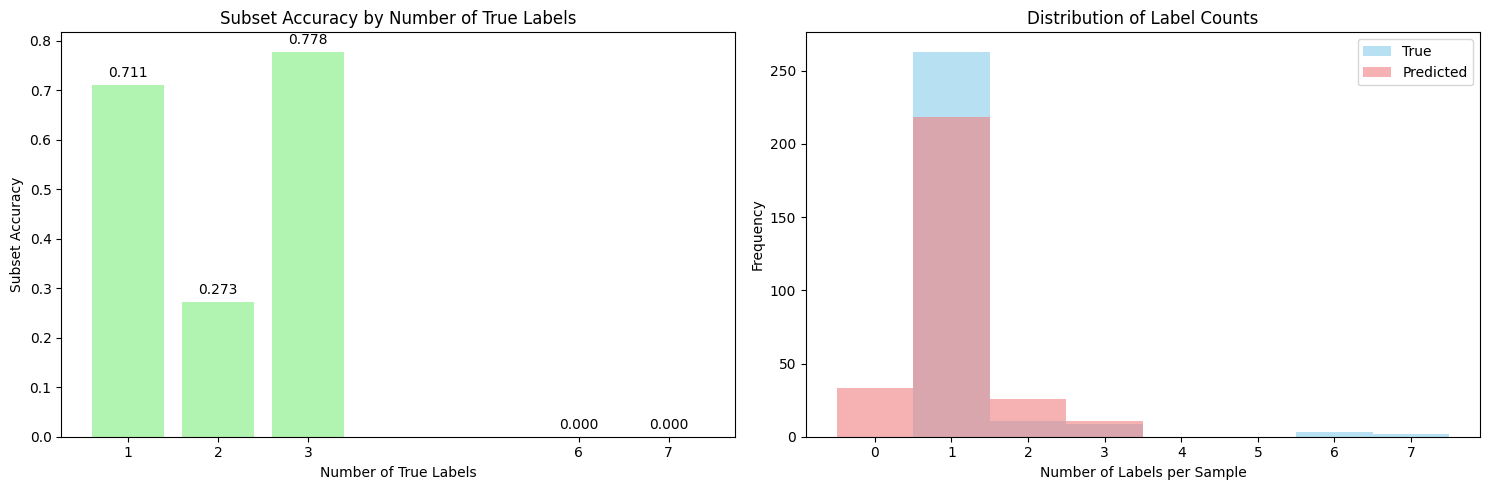

Overall Subset Accuracy: 0.684


In [13]:
# 如果是兩個分開的檔案
analysis = analyze_predictions_from_csv(
    pred_csv='/content/test_predictions.csv',
    true_csv='/content/image_classification_data/test_labels.csv',
    class_names=class_names
)